# **데이콘 Basic 쇼핑몰 리뷰 평점 분류 대회**


## **0. 대회 소개**

- 데이콘 Basic 쇼핑몰 리뷰 평점 분류 경진대회
  - [대회 링크](https://dacon.io/competitions/official/235938/overview/description)
- 상품 리뷰 텍스트만으로 상품의 평점을 예측
  - 주어진 쇼핑몰 리뷰 데이터셋을 이용하여 상품의 평점(1점, 2점, 4점, 5점)을 분류
- 심사 기준: ```accuracy```

## **1. 데이터 살펴보기**

### **1-0. 데이터 구조**

**1. train.csv**  
- 데이터 분석 모델을 학습(train)하기 위해 사용하는 데이터
  - ```id```: 샘플 아이디
  - ```reviews```: 쇼핑몰 리뷰 텍스트
  - ```target```: 상품 평점

**2. test.csv**  
- 데이터 분석 모델을 통해 정답을 예측하기 위해 사용하는 데이터
  - ```id```: 샘플 아이디
  - ```reviews```: 쇼핑몰 리뷰 텍스트

**3. sample_submission.csv**
- 예측한 정답 값을 기록하여 제출하기 위한 샘플 정답 파일
  - ```id```: 샘플 아이디
  - ```target```: 상품 평점

### **1-1. 데이터 준비**

In [ ]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# csv 형식의 training 데이터를 로드
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/mproject2/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project/mproject2/data/test.csv')

### **1-2. 데이터 확인**

In [ ]:
train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [ ]:
test.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


In [ ]:
# 데이터 형태 확인

print("train: ", train.shape)
print("test: ", test.shape)

train:  (25000, 3)
test:  (25000, 2)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   target   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


- 타겟 변수를 포함하여 총 3개의 변수와 25000건의 데이터로 이루어져 있음
- 결측치는 존재하지 X

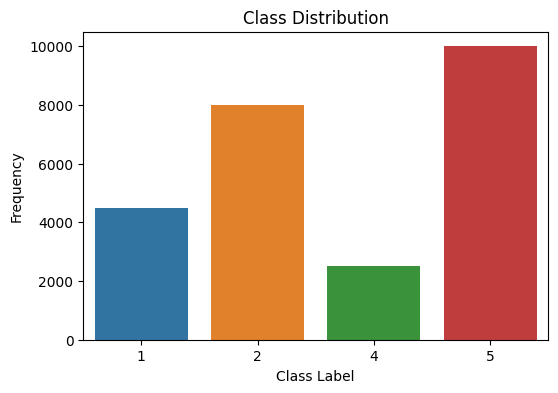

In [ ]:
## Target class의 구성 확인

import seaborn as sns
import matplotlib.pyplot as plt

# 클래스 레이블 값의 분포를 막대 그래프로 시각화
plt.figure(figsize = (6, 4))
sns.countplot(x = pd.Series(train['target']))
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# target 클래스의 값과 분포도 출력

print('target 클래스의 값과 분포도\n', pd.Series(train['target']).value_counts().sort_index())

target 클래스의 값과 분포도
 1     4500
2     8000
4     2500
5    10000
Name: target, dtype: int64


- 클래스 분포가 **불균형**한 것으로 판단됨
  - 오버샘플링 또는 언더샘플링 등을 고려할 수 있음

## **2. 텍스트 사전 준비(텍스트 전처리)**
- 텍스트를 피처로 만들기 전에 미리 대/소문자 변경, 특수문자 삭제 등의 클렌징 작업, 단어(word) 등의 토큰화 작업, 의미 없는 단어(stop word) 제거 작업, 어근 추출(Stemming/ Lemmatization) 등의 텍스트 정규화 작업을 수행하는 것

### **2-1. 데이터 정제(Cleaning)**
- 텍스트에서 분석에 오히려 방해가 되는 불필요한 문자, 기호 등을 사전에 제거하는 작업
- 정규 표현식을 활용하여 전처리 진행

In [ ]:
import re

# 빈 문자열 처리
train = train.fillna(' ')
# 숫자나 특수문자 제거
train['reviews'] = train['reviews'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))

# 테스트 데이터도 동일하게 전처리
test = test.fillna(' ')
test['reviews'] = test['reviews'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))

In [ ]:
# 정제된 데이터 확인

train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요,5


### **2-2. 토큰화(Tokenization)**
- 말뭉치(corpus)를 주어진 단위(token)로 나누는 과정
- **문장 토큰화**와 **단어 토큰화**로 구분됨
- 이후 프로젝트에서 활용할 피처 벡터화 방식은 **BoW(Bag of Word)** 기반 방식들임
  - 단어의 순서가 중요하지 않음
  - 해당 경우 단어 토큰화만 사용해도 충분함
---
- 한국어는 영어와 달리 형태소(뜻을 가진 말의 최소 단위)간의 결합으로 어절이 이루어짐
- 한국어에 대한 전처리는 대표적으로 ```koNlPy``` 패키지를 사용함

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.4 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Twitter   # Twitter 이용
twitter = Twitter() # tokenizer 생성

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
def token(df):
  tokenized = [] # 토큰화된 리뷰를 저장할 리스트

  # 전처리된 리뷰들을 하나씩 꺼내옴
  for sentence in df['reviews']:
    tokens = twitter.morphs(sentence, stem = True) # 형태소 분석 (stem = True로 설정해 어간 추출 진행)
    tokenize = " ".join(tokens) # tokens라는 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join
    tokenized.append(tokenize) # 형태소 단위로 띄어쓰기된 문자열을 최종 리스트에 추가

    df["tokenized_stem"] = pd.DataFrame(tokenized) # 리스트를 데이터프레임으로 변환해 tokenized_stem라는 컬럼으로 추가

In [ ]:
token(train)
token(test)

In [ ]:
train.head() # 데이터 확인

,id,reviews,target,tokenized_stem
0,0,조아요 처음구입 싸게햇어요,2,좋다 처음 구입 싸다 햇 어 요
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각 보다 자다 안 돼다 매다 바르다 하루 밖에 안 돼다 ㅠㅠ 25천원 가량 주다 ...
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인 은 괜찮다 상품 이 금 이 가다 교환 하다 두번째 받다 상품 도 끄다 안쪽 ...
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘...,2,기전 에 이 제품 말고 이마트 트 레이더스 에서만 파다 프리미엄 제품 을 사용 하다...
4,4,튼튼하고 손목을 잘 받쳐주네요,5,튼튼하다 손목 을 자다 받치다


In [ ]:
test.head()

,id,reviews,tokenized_stem
0,0,채소가 약간 시들어 있어요,채소 가 약간 시들다 있다
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍다 단단하다 분들 써다 소용없다 이 테이프 물렁거리 고 힘 이 없다 들다 ...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋다 입어보다 시원하다 또 살다
3,3,이런 1 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임,이렇다 1 8 골드 주 라니깐 파란 개 오다 회사 전화 걸다 받다 않다 머 하다 임
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수 도 없이 보내다 불량 배송비 5000원 청구 하다 완전 별로 별하나 도 아깝다


### **2-3. 품사 태깅(POS Tagging)**
- 주어진 텍스트를 형태소 단위로 나눈 뒤, 각 형태소에 해당 품사를 태깅하여 리스트화 하는 것


In [ ]:
def pos_tagging(df):
  main_pos = [] # 품사 태깅된 리뷰를 저장할 리스트

  # 전처리된 리뷰들을 하나씩 꺼내옴
  for sentence in df['tokenized_stem']:
      pos = twitter.pos(sentence) # 품사 태깅을 진행
      # 형용사, 명사, 부사, 동사, 숫자, 조사 추출
      main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ('Adjective', 'Noun', 'Adverb',
                                                                        'Verb', 'Number','KoreanParticle')]
      main_words_str = " ".join(main_words) # 선택한 형태소들로 이루어진 문자열을 최종 리스트에 추가
      main_pos.append(main_words_str) # 리스트에 추가

  df["pos_tagged"] = pd.DataFrame(main_pos) # 리스트를 데이터프레임의 새로운 열로 추가

In [ ]:
pos_tagging(train)
pos_tagging(test)

In [ ]:
train.head() # 데이터 확인

,id,reviews,target,tokenized_stem,pos_tagged
0,0,조아요 처음구입 싸게햇어요,2,좋다 처음 구입 싸다 햇 어 요,좋다 처음 구입 싸다 햇 요
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각 보다 자다 안 돼다 매다 바르다 하루 밖에 안 돼다 ㅠㅠ 25천원 가량 주다 ...,생각 보다 자다 안 돼다 매다 바르다 하루 안 돼다 ㅠㅠ 25천원 가량 주다 사기 ...
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인 은 괜찮다 상품 이 금 이 가다 교환 하다 두번째 받다 상품 도 끄다 안쪽 ...,디자인 은 괜찮다 상품 이 금 이 가다 교환 하다 두번째 받다 상품 도 끄다 안쪽 ...
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 샘...,2,기전 에 이 제품 말고 이마트 트 레이더스 에서만 파다 프리미엄 제품 을 사용 하다...,기전 이 제품 이마트 트 레이더스 파다 프리미엄 제품 사용 하다 샘플 써다 보고 마...
4,4,튼튼하고 손목을 잘 받쳐주네요,5,튼튼하다 손목 을 자다 받치다,튼튼하다 손목 자다 받치다


In [ ]:
test.head()

,id,reviews,tokenized_stem,pos_tagged
0,0,채소가 약간 시들어 있어요,채소 가 약간 시들다 있다,채소 가 약간 시들다 있다
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍다 단단하다 분들 써다 소용없다 이 테이프 물렁거리 고 힘 이 없다 들다 ...,발톱 두껍다 단단하다 써다 소용없다 이 테이프 물렁 거리 고 힘 이 없다 들다 리다...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋다 입어보다 시원하다 또 살다,부들부들 좋다 입어보다 시원하다 또 살다
3,3,이런 1 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임,이렇다 1 8 골드 주 라니깐 파란 개 오다 회사 전화 걸다 받다 않다 머 하다 임,이렇다 1 8 골드 주 파란 개 오다 회사 전화 걸다 받다 않다 머 하다 임
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수 도 없이 보내다 불량 배송비 5000원 청구 하다 완전 별로 별하나 도 아깝다,검수 도 없이 보내다 불량 배송비 5000원 청구 하다 완전 별로 별하나 도 아깝다


- **토큰화**와 **토큰화 + 품사 태깅**의 2가지 전처리 방법을 시도해 봄
- 이후 성능의 경우 여러 방법을 시도해 본 후 비교해 볼 예정

## **3. 데이터 정의**

### **3-1. Feature Selection**
- 독립변수(X)와 종속변수(target, y) 설정
  - 종속변수: 평점(target)
  - 독립변수: 리뷰 데이터(reviews)

In [ ]:
# 여기서는 일단 토큰화만 완료된 데이터를 활용(품사 태깅 x)

X1 = train['tokenized_stem']
y1 = train['target']

In [ ]:
X1.head()

0                                    좋다 처음 구입 싸다 햇 어 요
1    생각 보다 자다 안 돼다 매다 바르다 하루 밖에 안 돼다 ㅠㅠ 25천원 가량 주다 ...
2    디자인 은 괜찮다 상품 이 금 이 가다 교환 하다 두번째 받다 상품 도 끄다 안쪽 ...
3    기전 에 이 제품 말고 이마트 트 레이더스 에서만 파다 프리미엄 제품 을 사용 하다...
4                                     튼튼하다 손목 을 자다 받치다
Name: tokenized_stem, dtype: object

In [ ]:
y1.head()

0    2
1    1
2    2
3    2
4    5
Name: target, dtype: int64

### **3-2. train/validation 정의**
- 모델을 만들기 앞서 내가 만들 모델이 유의미한지 파악하는 것은 좋음
- 그러나, 단순히 주어진 데이터로 train set 데이터를 학습시켜서 목표값인 test set에 집어넣어 예측값을 도출하면, 모델이 적합한지 알 방법이 없음
  - 따라서, train set에서 70%를 학습을 시키는데 활용하고, 나머지 25%를 모델이 유의미한지 검증하는데 활용
  - 이후 유의미하다면 실제 모델 생성 시에는 train set을 100% 활용하면 됨

In [ ]:
from sklearn.model_selection import train_test_split

# stratify = true: target의 비율을 고려하여 train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1,test_size = 0.25, stratify = y1)

In [ ]:
# 데이터 형태 확인

print('학습용 데이터(train) : ', X_train1.shape)
print('검증용 데이터(val): ', X_val1.shape)

학습용 데이터(train) :  (18750,)
검증용 데이터(val):  (6250,)


- train 셋은 18750개, val 셋은 6250개 데이터로 나뉘어 진 것을 확인할 수 있음

## **4. 모델링**
- 사이킷런의 ```Pipeline``` 클래스응 이용해서 피처 벡터화와 ML 알고리즘 학습/예측을 위한 작업을 한 번에 수행
  - 데이터 전처리와 머신러닝 학습 과정을 통일된 API 기반에서 처리 -> 더 직관적인 ML 모델 코드를 생성
- 대표적으로 ```logistic regression```에 대해 텍스트 분류 수행

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### **피처 벡터화/추출**
- 컴퓨터는 일반적으로 문장(텍스트)을 계산할 수 없고 숫자를 입력받아 계산함
  - 텍스트와 같은 비정형 데이터는 머신러닝 알고리즘에 바로 입력할 수가 없음
  - 텍스트 데이터를 피처 형태로 추출하고 추출된 피처에 의미 있는 값을 부여하는 과정 필요
  > word embedding
- 대표적으로 ```BOW```와 ```Word2Vec```이 있음
  - BOW는 다시 Count 기반과 TF-IDF 기반으로 구분됨

#### **a. Count 기반 벡터화**
- 각 문서에서 해당 단어가 나타내는 횟수를 부여하는 경우
- 카운트 값이 높을수록 중요한 단어로 인식됨
  - 언어 특성상 자주 사용될 수밖에 없는 단어들에 대해서도 높은 값을 부여
---
**CountVectorizer**  
- 입력된 문장을 토큰화(Tokenize)하여 토큰의 등장 빈도 벡터로 바꿔주는 기법
  - 토큰화: 문장를 의미가 있는 최소의 단위로 쪼개는 것
- ```sklearn.CountVectorizer```를 통해 구현 가능
  - 학습을 통해 어떠한 단어들을 사용할 지, 어떠한 단어가 중요도를 가지는지 파악
    - 이때, 길이가 2 이하인 단어들 혹은 특수 문자 등 의미가 적다고 판된되는 단어들은 알아서 제거
  - 단어의 출현 빈도를 기준으로 문장을 벡터(= 숫자의 집합)으로 바꿔줌
- `vectorizer.vocabulary_`를 통해 학습한 단어 목록을 확인할 수 있음
  - 해당 단어들을 기준으로 새로운 문장을 숫자로 바꿔줄 수 있음
- 학습된 vectorizer를 이용해 다른 문장을 벡터로 transform 할 수 있음
  - 단어 목록에 있는 단어들의 출현 빈도로 이루어진 벡터가 반환됨
  > BoW(Bag of Words)
- BoW는 각 단어가 등장한 **횟수**를 수치화하는 텍스트 표현 방법임
  - 주로 어떤 단어가 얼마나 등장했는지를 기준으로 문서가 어떤 성격의 문서인지를 판단하는 작업에 활용됨



In [ ]:
# Pipeline 생성 - CountVectorizer 사용
count = Pipeline([
    ('count_vect', CountVectorizer()),
    ('lr_clf', LogisticRegression(solver='liblinear'))
])

In [ ]:
# 하이퍼파라미터 설정
params = {
    'count_vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'count_vect__max_df': [100, 300, 700],
    'lr_clf__C': [1, 5, 10]
}

# GridSearchCV 적용
count_cv1 = GridSearchCV(count, param_grid = params, cv = 3,
                        scoring = 'accuracy', verbose = 1)
count_cv1.fit(X_train1, y_train1)

print(count_cv1.best_params_, count_cv1.best_score_)

pred1 = count_cv1.predict(X_val1)
print('CountVectorizer 피처 벡터화 된 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_val1, pred1)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'count_vect__max_df': 700, 'count_vect__ngram_range': (1, 3), 'lr_clf__C': 1} 0.6231466666666666
CountVectorizer 피처 벡터화 된 Logistic Regression의 예측 정확도는 0.623


### **b. TF-IDF(Term Frequency - Inverse Document Frequency)**
- TF(단어 빈도, term frequency)
  - 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값
- IDF(역문서 빈도, inverse document frequency)
  - 단어 자체가 문서군 내에서 자주 사용하여 얼마나 그 단어가 흔하게 등장하는지를 나타내는 값의 역수를 곱한 값  
- 특정 문서 내에서 단어 빈도가 높을수록, 그리고 전체 문서들 중 해당 단어를 포함한 문서가 적을수록 TF-IDF값이 높아짐
  - 특정 단어를 포함하는 문서들이 많을수록 로그 함수 안의 값이 1에 가까워지게 되고, 이 경우 IDF값과 TF-IDF값은 0에 가까워지게 되는 것임
  - 따라서, 이 값을 활용하면 모든 문서에 흔하게 나타나는 단어를 걸러내는 효과를 얻을 수 있음
- TF-IDF는 주로 문서의 유사도를 구하는 작업, 검색 시스템에서 검색 결과의 중요도를 정하는 작업,
문서 내에서 특정 단어의 중요도를 구하는 작업 등에 활용됨


In [ ]:
## Pipeline 생성 - TfidfVectorizer 사용

tf_idf = Pipeline([
    ('tfidf_vect', TfidfVectorizer()),
    ('lr_clf', LogisticRegression(solver = 'liblinear'))
])

In [ ]:
# Pipeline에 기술된 각각의 객체 변수에 언더바(_) 2개를 연달아 붙여 GridSearchCV에 사용될
# 파라미터/하이퍼 파라미터 이름과 값을 설정
params = { 'tfidf_vect__ngram_range': [(1,1), (1,2), (1,3)],
           'tfidf_vect__max_df': [100, 300, 700],
           'lr_clf__C': [1,5,10]
}

# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
tf_idf_cv1 = GridSearchCV(tf_idf, param_grid = params, cv = 3 ,
                          scoring = 'accuracy',verbose = 1)
tf_idf_cv1.fit(X_train1, y_train1)
print(tf_idf_cv1.best_params_, tf_idf_cv1.best_score_)

pred1 = tf_idf_cv1.predict(X_val1)
print('TF-IDF 피처 벡터화 된 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_val1 ,pred1)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'lr_clf__C': 1, 'tfidf_vect__max_df': 700, 'tfidf_vect__ngram_range': (1, 2)} 0.6329600000000001
TF-IDF 피처 벡터화 된 Logistic Regression의 예측 정확도는 0.636


* 여기서부터는 토큰화에 품사 태깅까지 완료한 데이터를 사용하여 모델링

In [ ]:
# 토큰화 + pos
X2 = train['pos_tagged']
y2 = train['target']

In [ ]:
X2.head()

0                                      좋다 처음 구입 싸다 햇 요
1    생각 보다 자다 안 돼다 매다 바르다 하루 안 돼다 ㅠㅠ 25천원 가량 주다 사기 ...
2    디자인 은 괜찮다 상품 이 금 이 가다 교환 하다 두번째 받다 상품 도 끄다 안쪽 ...
3    기전 이 제품 이마트 트 레이더스 파다 프리미엄 제품 사용 하다 샘플 써다 보고 마...
4                                       튼튼하다 손목 자다 받치다
Name: pos_tagged, dtype: object

In [ ]:
y2.head()

0    2
1    1
2    2
3    2
4    5
Name: target, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# stratify = true: target의 비율을 고려하여 train_test_split
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2,test_size = 0.25, stratify = y2)

In [ ]:
# 데이터 형태 확인

print('학습용 데이터(train) : ', X_train2.shape)
print('검증용 데이터(val): ', X_val2.shape)

학습용 데이터(train) :  (18750,)
검증용 데이터(val):  (6250,)


In [ ]:
# Pipeline 생성 - CountVectorizer 사용
count = Pipeline([
    ('count_vect', CountVectorizer()),
    ('lr_clf', LogisticRegression(solver='liblinear'))
])

In [ ]:
# 하이퍼파라미터 설정
params = {
    'count_vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'count_vect__max_df': [100, 300, 700],
    'lr_clf__C': [1, 5, 10]
}

# GridSearchCV 적용
count_cv2 = GridSearchCV(count, param_grid = params, cv = 3,
                        scoring = 'accuracy', verbose = 1)
count_cv2.fit(X_train2, y_train2)

print(count_cv2.best_params_, count_cv2.best_score_)

pred2 = count_cv2.predict(X_val2)
print('CountVectorizer 피처 벡터화 된 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_val2, pred2)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'count_vect__max_df': 700, 'count_vect__ngram_range': (1, 3), 'lr_clf__C': 1} 0.62064
CountVectorizer 피처 벡터화 된 Logistic Regression의 예측 정확도는 0.629


In [ ]:
## Pipeline 생성 - TfidfVectorizer 사용

tf_idf = Pipeline([
    ('tfidf_vect', TfidfVectorizer()),
    ('lr_clf', LogisticRegression(solver = 'liblinear'))
])

In [ ]:
# Pipeline에 기술된 각각의 객체 변수에 언더바(_) 2개를 연달아 붙여 GridSearchCV에 사용될
# 파라미터/하이퍼 파라미터 이름과 값을 설정
params = { 'tfidf_vect__ngram_range': [(1,1), (1,2), (1,3)],
           'tfidf_vect__max_df': [100, 300, 700],
           'lr_clf__C': [1,5,10]
}

# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
tf_idf_cv2 = GridSearchCV(tf_idf, param_grid = params, cv = 3 ,
                          scoring = 'accuracy',verbose = 1)
tf_idf_cv2.fit(X_train2, y_train2)
print(tf_idf_cv2.best_params_, tf_idf_cv2.best_score_)

pred2 = tf_idf_cv2.predict(X_val2)
print('TF-IDF 피처 벡터화 된 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_val2 ,pred2)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'lr_clf__C': 1, 'tfidf_vect__max_df': 700, 'tfidf_vect__ngram_range': (1, 2)} 0.6294933333333333
TF-IDF 피처 벡터화 된 Logistic Regression의 예측 정확도는 0.634


* 토큰화 + CountVectorizer 피처 벡터화 + 로지스틱 => 0.623
* 토큰화 + TF-IDF 피처 벡터화 + 로지스틱 => **0.636**
* 토큰화 + 품사 태깅 + CountVectorizer 피처 벡터화 + 로지스틱 => 0.629
* 토큰화 + 품사 태깅 + TF-IDF 피처 벡터화 + 로지스틱 => 0.634